# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Сервисом предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Целью данного проекта является построение модели для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
**Признаки**
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **NotRepaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

**Целевой признак**
* **Price** — цена (евро)

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

C:\Users\Lenin\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Lenin\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Lenin\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pth1 = '/datasets/autos.csv'
pth2 = 'autos.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Уберем из датасета неинформативные признаки: дату скачивания анкеты из базы, дату создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дату последней активности пользователя, месяц регистрации

In [4]:
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis='columns',inplace=True)

In [5]:
#посмотрим долю пропущенных значений по каждому столбцу
df.isnull().sum(axis=0)/len(df)

Price               0.000000
VehicleType         0.105794
RegistrationYear    0.000000
Gearbox             0.055967
Power               0.000000
Model               0.055606
Kilometer           0.000000
FuelType            0.092827
Brand               0.000000
NotRepaired         0.200791
dtype: float64

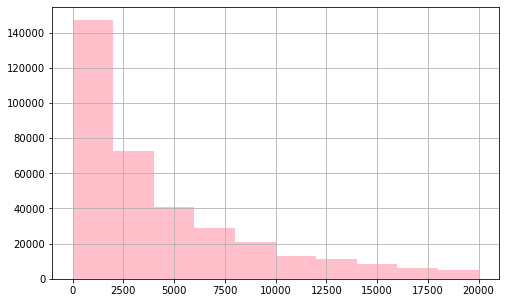

In [6]:
# проверим распределение стоимости авто
df.Price.hist(figsize=(8, 5), color = 'pink');

In [7]:
len(df.query('Price == 0'))

10772

Мы видим, что в 10772 объявлений (около 3%) отсутствует стоимость авто. Поскольку это является целевым признаком, данные объявления не подойдут для обучения модели, удалим их из датасета.

In [8]:
df = df.loc[df['Price'] != 0]

In [9]:
df.isnull().sum(axis=0)/len(df)

Price               0.000000
VehicleType         0.098226
RegistrationYear    0.000000
Gearbox             0.050510
Power               0.000000
Model               0.050993
Kilometer           0.000000
FuelType            0.085737
Brand               0.000000
NotRepaired         0.191696
dtype: float64

Для стобцов: тип автомобильного кузова, тип коробки передач, модель автомобиля, тип топлива, была машина в ремонте или нет остались пропущенные значения. Чтобы не потерять эти данные, заменим пропущенные значения на 'unknown'

In [10]:
for x in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    df[x] = df[x].fillna('unknown')

In [11]:
df.isnull().sum(axis=0)/len(df)

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64

In [12]:
# посмотрим на год регистрации автомобилей
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946], dtype=int64)

В данных о годе регистрации автомобилей присутстсвует болшое количество номалий, ограничим данные от 1900 до 2016 года

In [13]:
df = df.query('RegistrationYear >= 1900 & RegistrationYear <=2016')

In [14]:
# проверим значения мощности автомобиля
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    50,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   280,   260,   104,   188,   333,   186,   117,   141,
         132,   234,   158,    39,    92,    51,   135,    59,   230,
          53,   209,

 ограничим мощность автомобиля 1600 л.с.

In [15]:
df = df.query('Power <= 1600')

In [16]:
#проверим данные на наличие дубликатов
df.duplicated().sum()

42309

In [17]:
#уберем дубликаты из датасета
df.drop_duplicates(inplace=True)

## Обучение моделей

**Линейная регрессия**

Закодируем категориальные признаки техникой OHE

In [18]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
354365,2200,2005,0,20000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
354366,1199,2000,101,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    df_ohe.drop('Price', axis=1), df_ohe.Price, test_size=0.25, random_state=12345) 

Поскольку для заказчика важны скорость предскзния и время обучения, воспользуемся для посчета затрченного времени функцией time() модуля time

In [20]:
%%time
model = LinearRegression()
start_fit = time.time()
model.fit(features_train, target_train)
end_fit = time.time()

Wall time: 8.46 s


проверим качество модели на кроссвалидации

In [21]:
score = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_squared_error', cv=5)
rmse = np.mean(np.sqrt(np.abs(score)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 2819.97


In [22]:
%%time
start_predict = time.time()
pred = model.predict(features_train)
end_predict = time.time()

Wall time: 882 ms


Для сравнения результатов создадим дтафрейм, в котором укажем название модели, ее качество(RMSE), время обучения модели, время предсказания модели:

In [23]:
metrics_df = pd.DataFrame(columns=['model', 'RMSE', 'time_fit', 'time_predict'])

In [24]:
metrics_df = metrics_df.append({
    'model': 'LinearRegression',
    'RMSE': rmse,
    'time_fit': end_fit-start_fit,
    'time_predict': end_predict - start_predict
}, ignore_index=True)

metrics_df

<ipython-input-24-06290e0eae47>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494


**CatBoost**

Поскольку CatBoost умеет работать с категориальными признаками, возьмем данные без изменений

In [25]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.40, random_state=12345) 

In [26]:
features_val, features_test, target_val, target_test = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345) 

In [27]:
cat_features = df.select_dtypes("object").columns.tolist()

In [28]:
%%time
model = CatBoostRegressor(loss_function="RMSE", iterations=50)
start_fit = time.time()
model.fit(features_train, target_train, cat_features=cat_features, verbose = False, plot = True)
end_fit = time.time()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 6.51 s


проверим качество модели на валидационной выборке

In [29]:
%%time
start_predict = time.time()
pred = model.predict(features_val)
end_predict = time.time()
rmse = (np.sqrt(mean_squared_error(target_val, pred)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1763.14
Wall time: 175 ms


Посмотрим словарь со всеми параметрами модели

In [30]:
for key,value in model.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, RMSE
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations, 50
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
one_hot_max_size, 2
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
max_ctr_complexity, 1
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}}
sub

Добавим результат в сравнительный датафрейм:

In [31]:
metrics_df = metrics_df.append({
    'model': 'CatBoostRegressor',
    'RMSE': rmse,
    'time_fit': end_fit-start_fit,
    'time_predict': end_predict - start_predict
}, ignore_index=True)

metrics_df

<ipython-input-31-167bcc0e8bda>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494
1,CatBoostRegressor,1763.136002,6.506974,0.173702


попробуем настроить параметры модели и сравнить результат

In [32]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.20, random_state=12345) 

In [33]:

model = CatBoostRegressor(loss_function="RMSE", iterations=50)
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
Grid_CBR = GridSearchCV(estimator=model, param_grid = grid, cv = 3, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [34]:
%%time
Grid_CBR.fit(features_train, target_train, cat_features=cat_features, verbose = False)

Wall time: 13min 17s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000016697A7DFA0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.03, 0.1, 0.5]},
             scoring='neg_root_mean_squared_error')

In [35]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBR.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBR.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 -1713.794138293498

 The best parameters across ALL searched params:
 {'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.5}


In [36]:
%%time
model = CatBoostRegressor(loss_function="RMSE", iterations=50, depth = 10, l2_leaf_reg = 3, learning_rate = 0.5)
start_fit = time.time()
model.fit(features_train, target_train, cat_features=cat_features, verbose = False, plot = True)
end_fit = time.time()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 13.3 s


In [37]:
%%time
start_predict = time.time()
pred = model.predict(features_train)
end_predict = time.time()
rmse = (np.sqrt(mean_squared_error(target_train, pred)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1609.00
Wall time: 985 ms


добавим результат в сравнительную тблицу

In [38]:
metrics_df = metrics_df.append({
    'model': 'CatBoostRegressor tuning',
    'RMSE': rmse,
    'time_fit': end_fit-start_fit,
    'time_predict': end_predict - start_predict
}, ignore_index=True)

metrics_df

<ipython-input-38-c31dd7f999d0>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494
1,CatBoostRegressor,1763.136002,6.506974,0.173702
2,CatBoostRegressor tuning,1608.998575,13.302320,0.981438


**LGBM**

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.40, random_state=12345)

In [45]:
features_val, features_test, target_val, target_test = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345) 

In [46]:

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']
for c in cat_features:
    df[c] = df[c].astype('category')
start_fit = time.time()
LGBM_model = LGBMRegressor(random_state = 12345)
LGBM_model.fit(features_train, target_train, categorical_feature=cat_features)
end_fit = time.time()

C:\Users\Lenin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


проверим качество на валидационной выборке

In [47]:
%%time
start_predict = time.time()
pred = LGBM_model.predict(features_val)
end_predict = time.time()
rmse = (np.sqrt(mean_squared_error(target_val, pred)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1666.86
Wall time: 363 ms


In [48]:
#посмотрим на параметры обученной модели
for key,value in LGBM_model.get_params(deep=True).items():
    print('{}, {}'.format(key,value))

boosting_type, gbdt
class_weight, None
colsample_bytree, 1.0
importance_type, split
learning_rate, 0.1
max_depth, -1
min_child_samples, 20
min_child_weight, 0.001
min_split_gain, 0.0
n_estimators, 100
n_jobs, -1
num_leaves, 31
objective, None
random_state, 12345
reg_alpha, 0.0
reg_lambda, 0.0
silent, warn
subsample, 1.0
subsample_for_bin, 200000
subsample_freq, 0


In [49]:
metrics_df = metrics_df.append({
    'model': 'LGBMRegressor',
    'RMSE': rmse,
    'time_fit': end_fit-start_fit,
    'time_predict': end_predict - start_predict
}, ignore_index=True)

metrics_df

<ipython-input-49-a922749b6a73>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494
1,CatBoostRegressor,1763.136002,6.506974,0.173702
2,CatBoostRegressor tuning,1608.998575,13.302320,0.981438
3,LGBMRegressor,1666.856919,1.676040,0.360792


настроим параметры модели с помощью GridSearchCV

In [50]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.20, random_state=12345)

In [51]:
model = LGBMRegressor()
grid = {'learning_rate': [0.03, 0.1, 0.2, 0.5],
        'num_leaves': [30, 31, 32, 33]}
Grid_lgbm = GridSearchCV(estimator=model, param_grid = grid, cv = 2, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [52]:
%%time
Grid_lgbm.fit(features_train, target_train, categorical_feature=cat_features)

C:\Users\Lenin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Wall time: 51.5 s


GridSearchCV(cv=2, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1, 0.2, 0.5],
                         'num_leaves': [30, 31, 32, 33]},
             scoring='neg_root_mean_squared_error')

In [53]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_lgbm.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_lgbm.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_lgbm.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.2, num_leaves=33)

 The best score across ALL searched params:
 -1678.9600837867138

 The best parameters across ALL searched params:
 {'learning_rate': 0.2, 'num_leaves': 33}


In [54]:
%%time
start_fit = time.time()
LGBM_model = LGBMRegressor(learning_rate = 0.2, num_leaves = 33, random_state = 12345)
LGBM_model.fit(features_train, target_train, categorical_feature=cat_features)
end_fit = time.time()

C:\Users\Lenin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Wall time: 1.86 s


In [55]:
%%time
start_predict = time.time()
pred = LGBM_model.predict(features_train)
end_predict = time.time()
rmse = (np.sqrt(mean_squared_error(target_train, pred)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1573.20
Wall time: 1.18 s


In [56]:
metrics_df = metrics_df.append({
    'model': 'LGBMRegressor tuning',
    'RMSE': rmse,
    'time_fit': end_fit-start_fit,
    'time_predict': end_predict - start_predict
}, ignore_index=True)

metrics_df

<ipython-input-56-64092b05235a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494
1,CatBoostRegressor,1763.136002,6.506974,0.173702
2,CatBoostRegressor tuning,1608.998575,13.302320,0.981438
3,LGBMRegressor,1666.856919,1.676040,0.360792
4,LGBMRegressor tuning,1573.197969,1.859935,1.173330


## Анализ моделей

Выведем полученную сравнительную таблицу

In [57]:
metrics_df

,model,RMSE,time_fit,time_predict
0,LinearRegression,2819.970935,8.461165,0.882494
1,CatBoostRegressor,1763.136002,6.506974,0.173702
2,CatBoostRegressor tuning,1608.998575,13.302320,0.981438
3,LGBMRegressor,1666.856919,1.676040,0.360792
4,LGBMRegressor tuning,1573.197969,1.859935,1.173330


Наилучшее качество по метрике RMSE показал LGBMRegressor со следующими подобранными параметрами: LGBMRegressor(learning_rate = 0.2, num_leaves = 33, random_state = 12345). Время обучения для данной гораздо меньше, чем у Catboost. Однако у Catboost выше скорость предсказания. Наименьшее качество показала модель Линейной регресси, однако ее значения RMSE в два раза хуже, чем у бустингов. Для решения поставленной задачи рекомендуется использовать LGBMRegressor с подобранными гиперпараметрами:LGBMRegressor(learning_rate = 0.2, num_leaves = 33, random_state = 12345). Проверим ее качество на отложенной тестовой выборке:

In [58]:
pred = LGBM_model.predict(features_test)
rmse = (np.sqrt(mean_squared_error(target_test, pred)))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 1651.37


На отложенной тестовой выборке качество модели оказалось меньше порогового значения (RMSE = 2500), таким образом данная модель зарекомедовала себя наилучшим образом и может быть отправлена заказчику.